In [1]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import itertools

from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

import xgboost as xgb

### Data

In [2]:
x_train = "data/processed/bank_train.csv"
x_test = "data/processed/bank_test.csv"
x_val = "data/processed/bank_val.csv"

x_train_data = pd.read_csv(x_train)
x_test_data = pd.read_csv(x_test)
x_val_data = pd.read_csv(x_val)

x_train_data.drop(x_train_data.columns[0], axis=1, inplace=True)
x_test_data.drop(x_test_data.columns[0], axis=1, inplace=True)
x_val_data.drop(x_val_data.columns[0], axis=1, inplace=True)

In [3]:
y_train = "data/processed/bank_train_labels.csv"
y_test = "data/processed/bank_test_labels.csv"
y_val = "data/processed/bank_val_labels.csv"

y_train_data = pd.read_csv(y_train)
y_test_data = pd.read_csv(y_test)
y_val_data = pd.read_csv(y_val)

y_train_data.drop(y_train_data.columns[0], axis=1, inplace=True)
y_test_data.drop(y_test_data.columns[0], axis=1, inplace=True)
y_val_data.drop(y_val_data.columns[0], axis=1, inplace=True)

In [4]:
x_test = pd.concat([x_test_data, x_val_data], ignore_index=True)
y_test = pd.concat([y_test_data, y_val_data], ignore_index=True)

In [5]:
label_counts = np.bincount(y_train_data["target"])

print("Train Data")
print("Total Data Points: ", len(x_train_data))
print(f"Marketing Successful: {label_counts[0]}")
print(f"Marketing Failed: {label_counts[1]}")

label_counts = np.bincount(y_test["target"])

print("\nTest Data")
print("Total Data Points: ", len(x_test))
print(f"Marketing Successful: {label_counts[0]}")
print(f"Marketing Failed: {label_counts[1]}")



Train Data
Total Data Points:  30742
Marketing Successful: 27133
Marketing Failed: 3609

Test Data
Total Data Points:  14469
Marketing Successful: 12789
Marketing Failed: 1680


### Estimators

In [7]:
svm_clf_linear = SVC(C=34,
                     kernel='linear',
                     class_weight='balanced')

svm_clf_rbf = SVC(C=34, class_weight='balanced')

svm_clf_poly = SVC(C=25, kernel='poly', degree=3, gamma=0.01)

### Logging Multiple BaggingClassifier parameters and metrics using MLFlow

In [8]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [5, 10],
    "max_samples": [0.6, 0.9],
    "max_features": [0.6, 0.9],
    "bootstrap": [True, False]
}

# Create combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid["n_estimators"],
    param_grid["max_samples"],
    param_grid["max_features"],
    param_grid["bootstrap"]
))

print("Number of parameter combinations: ", len(param_combinations))

Number of parameter combinations:  16


In [9]:
def eval_metrics(actual, pred):
    acc = accuracy_score(actual, pred)
    rec = recall_score(actual, pred)
    pre = precision_score(actual, pred)
    f1_scr = f1_score(actual, pred)
    return acc, rec, pre, f1_scr

In [26]:
# Start MLflow experiment
mlflow.set_experiment("8_SVC_poly_BaggingClassifier")

for n_estimators, max_samples, max_features, bootstrap in param_combinations:
    with mlflow.start_run():
        # Initialize the BaggingClassifier
        model = BaggingClassifier(
            estimator=svm_clf_poly,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            bootstrap=bootstrap,
            n_jobs=-1
        )

        # Train and evaluate
        model.fit(x_train_data, y_train_data["target"])
        y_pred = model.predict(x_test)

        # Metrics
        acc, rec, pre, f1_scr = eval_metrics(y_test["target"], y_pred)

        # Signature
        # signature = infer_signature(x_train_data[:10000], y_train_data[:10000]["target"])

        # Log parameters and metrics
        metric_eval = {"Accuracy": acc, "Recall": rec, "Precision": pre, "F1 Score": f1_scr}
        mlflow.log_metrics(metric_eval)
        
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_samples", max_samples)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("bootstrap", bootstrap)

        # Optionally log the model
        # mlflow.sklearn.log_model(model, "model", signature=signature)

        print(f"Run complete: Estimators={n_estimators}, Samples={max_samples}, Features={max_features}, Bootstrap={bootstrap},\nRecall={rec:.2f}, Precision={pre:.2f}")

2025/06/10 15:51:35 INFO mlflow.tracking.fluent: Experiment with name '8_SVC_poly_BaggingClassifier' does not exist. Creating a new experiment.


Run complete: Estimators=5, Samples=0.6, Features=0.6, Bootstrap=True,
Recall=0.01, Precision=0.70
Run complete: Estimators=5, Samples=0.6, Features=0.6, Bootstrap=False,
Recall=0.00, Precision=0.38
Run complete: Estimators=5, Samples=0.6, Features=0.9, Bootstrap=True,
Recall=0.08, Precision=0.65
Run complete: Estimators=5, Samples=0.6, Features=0.9, Bootstrap=False,
Recall=0.07, Precision=0.68
Run complete: Estimators=5, Samples=0.9, Features=0.6, Bootstrap=True,
Recall=0.01, Precision=0.71
Run complete: Estimators=5, Samples=0.9, Features=0.6, Bootstrap=False,
Recall=0.02, Precision=0.58
Run complete: Estimators=5, Samples=0.9, Features=0.9, Bootstrap=True,
Recall=0.08, Precision=0.67
Run complete: Estimators=5, Samples=0.9, Features=0.9, Bootstrap=False,
Recall=0.09, Precision=0.66
Run complete: Estimators=10, Samples=0.6, Features=0.6, Bootstrap=True,
Recall=0.01, Precision=0.58


C:\Users\SaratKarasala\.conda\envs\python-ml-1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run complete: Estimators=10, Samples=0.6, Features=0.6, Bootstrap=False,
Recall=0.00, Precision=0.00
Run complete: Estimators=10, Samples=0.6, Features=0.9, Bootstrap=True,
Recall=0.06, Precision=0.67
Run complete: Estimators=10, Samples=0.6, Features=0.9, Bootstrap=False,
Recall=0.05, Precision=0.66
Run complete: Estimators=10, Samples=0.9, Features=0.6, Bootstrap=True,
Recall=0.01, Precision=0.65
Run complete: Estimators=10, Samples=0.9, Features=0.6, Bootstrap=False,
Recall=0.01, Precision=0.76
Run complete: Estimators=10, Samples=0.9, Features=0.9, Bootstrap=True,
Recall=0.09, Precision=0.66
Run complete: Estimators=10, Samples=0.9, Features=0.9, Bootstrap=False,
Recall=0.08, Precision=0.66


### Training Model


### Bagging Classifier

### Best Parameters for BaggingClassifier

In [27]:
classifier = None
classifier = BaggingClassifier(estimator = svm_clf_rbf,
                               n_estimators = 5,
                               max_samples = 0.6,
                               max_features = 0.6,
                               bootstrap = False,
                               warm_start = False,
                               n_jobs = -1
                              )

history = classifier.fit(x_train_data, y_train_data["target"])

In [28]:
y_pred = classifier.predict(x_test)

### Metrics

#### Confusion Matrix

In [34]:
confusionMatrix = confusion_matrix(y_test, y_pred)
confusionMatrixNorm = confusion_matrix(y_test, y_pred, normalize='pred')

fig, axes = plt.subplots(1,2, figsize=(11,4))

sns.heatmap(confusionMatrix, annot=True, ax=axes[0], cmap='YlGnBu', fmt="d")
axes[0].set_title("Confusion Matrix")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

sns.heatmap(confusionMatrixNorm, annot=True, cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Normalized Predictions")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

plt.show()

#### Classification Report

In [33]:
target_names = ['Unsuccessful', 'Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

### ROC Curve

In [32]:
probabilities = classifier.predict_proba(x_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test,  probabilities)
auc = roc_auc_score(y_test, probabilities)

plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

### Custom Threshold

In [ ]:
threshold = 0.5
custom_predictions = (probabilities > threshold).astype(int)

## Results

### Bagging Classifier - Decision Tree

#### Confusion Matrix

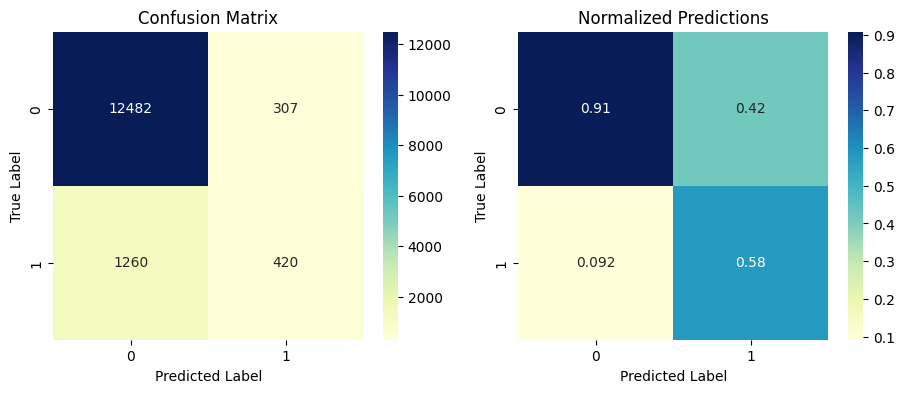

#### Classification Report

              precision    recall  f1-score   support

Unsuccessful       0.91      0.98      0.94     12789
  Successful       0.58      0.25      0.35      1680

    accuracy                           0.89     14469
   macro avg       0.74      0.61      0.64     14469
weighted avg       0.87      0.89      0.87     14469



### Bagging Classifier - Linear SVC

#### Confusion Matrix

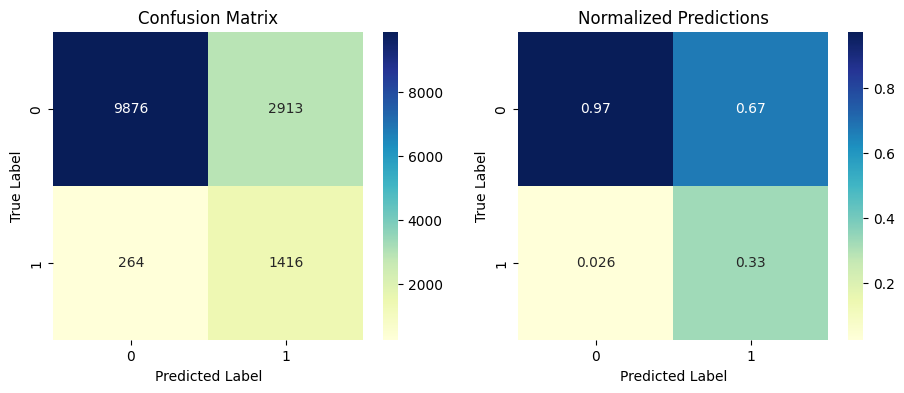

#### Classification Report

              precision    recall  f1-score   support

Unsuccessful       0.97      0.77      0.86     12789
  Successful       0.33      0.84      0.47      1680

    accuracy                           0.78     14469
   macro avg       0.65      0.81      0.67     14469
weighted avg       0.90      0.78      0.82     14469



### Bagging Classifier - SVC RBF

#### Confusion Matrix

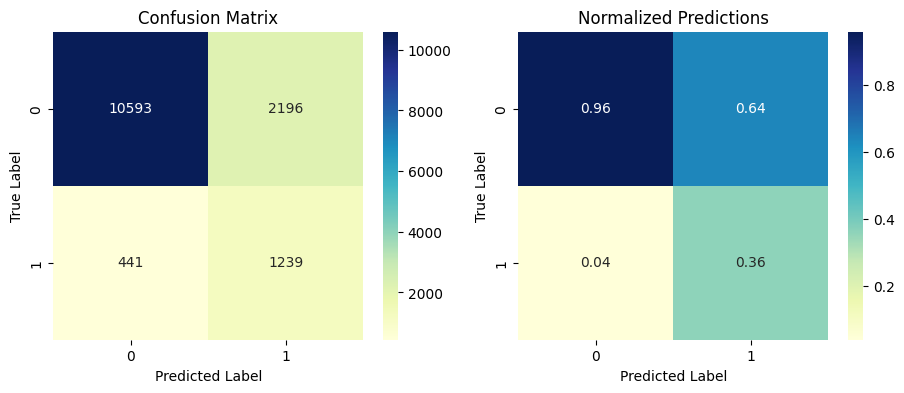

#### Classification Report

              precision    recall  f1-score   support

Unsuccessful       0.96      0.83      0.89     12789
  Successful       0.36      0.74      0.48      1680

    accuracy                           0.82     14469
   macro avg       0.66      0.78      0.69     14469
weighted avg       0.89      0.82      0.84     14469

